In [53]:
import os
import shutil
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Caminho do diretório principal de resultados
results_dir = "resultados"

# Verifica se o diretório existe e o remove
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)

# Recria o diretório e seus subdiretórios
output_dirs = {
    "hill_climbing": os.path.join(results_dir, "Subida de encosta"),
    "simulated_annealing": os.path.join(results_dir, "Têmpera Simulada"),
    "alg_conj": os.path.join(results_dir, "Algoritmos em conjunto"),
    "hist": os.path.join(results_dir, "Histogramas"),
    "dxl": os.path.join(results_dir, "DxI"),
    "est_dist": os.path.join(results_dir, "estatisticas_distancia")
}

# Criar as pastas novamente
for directory in output_dirs.values():
    os.makedirs(directory, exist_ok=True)

# Carregar imagem
image_path = "/content/dados.png"
image = cv2.imread(image_path)

# Verificar se a imagem foi carregada corretamente
if image is None:
    raise FileNotFoundError(f"Erro: Não foi possível carregar a imagem em {image_path}")

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Definir intervalo para vermelho
lower_red1 = np.array([0, 120, 100], dtype=np.uint8)
upper_red1 = np.array([10, 255, 255], dtype=np.uint8)
lower_red2 = np.array([170, 120, 100], dtype=np.uint8)
upper_red2 = np.array([180, 255, 255], dtype=np.uint8)

# Criar máscara
mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
red_mask = cv2.bitwise_or(mask1, mask2)

# Detectar cidades
contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cities = np.array([cv2.boundingRect(cnt)[:2] for cnt in contours])

if len(cities) == 0:
    raise ValueError("Nenhuma cidade detectada na imagem.")

# Função para calcular a distância total do caminho
def total_distance(cities, path):
    return sum(np.linalg.norm(cities[path[i]] - cities[path[i-1]]) for i in range(len(path)))

In [54]:
# Algoritmo de Subida de Encosta
def hill_climbing(cities, max_iters=1000):
    n = len(cities)
    best_path = list(range(n))
    random.shuffle(best_path)
    best_dist = total_distance(cities, best_path)

    for _ in range(max_iters):
        i, j = sorted(random.sample(range(n), 2))
        new_path = best_path[:i] + best_path[i:j+1][::-1] + best_path[j+1:]
        new_dist = total_distance(cities, new_path)

        if new_dist < best_dist:
            best_path, best_dist = new_path, new_dist

    return best_path, best_dist

In [55]:
# Algoritmo de Têmpera Simulada
def simulated_annealing(cities, initial_temp=100, cooling_rate=0.995, max_iters=10000):
    n = len(cities)
    path = list(range(n))
    random.shuffle(path)
    dist = total_distance(cities, path)
    temp = initial_temp

    for _ in range(max_iters):
        i, j = sorted(random.sample(range(n), 2))
        new_path = path[:i] + path[i:j+1][::-1] + path[j+1:]
        new_dist = total_distance(cities, new_path)

        if new_dist < dist or random.random() < np.exp((dist - new_dist) / temp):
            path, dist = new_path, new_dist

        temp *= cooling_rate
        if temp < 1e-8:
            break

    return path, dist

In [56]:
# Função para plotar e salvar imagem
def plot_and_save(cities, path, title, filename):
    plt.figure(figsize=(8, 6))
    plt.scatter(cities[:, 0], -cities[:, 1], c='red')

    # Corrigir erro de índice fora do intervalo
    ordered_cities = cities[np.append(path, path[0])]
    plt.plot(ordered_cities[:, 0], -ordered_cities[:, 1], 'b-')
    plt.title(title)
    plt.savefig(filename)
    plt.close()

In [57]:
# Salvar resultados
hc_results, sa_results = [], []

In [58]:
import time

hc_results = []
hc_times = []

# Executar e salvar resultados da Subida de Encosta
for i in range(10):
    start_time = time.time()  # Início da contagem do tempo
    hc_path, hc_dist = hill_climbing(cities)
    end_time = time.time()  # Fim da contagem do tempo

    execution_time = end_time - start_time  # Tempo decorrido

    hc_results.append(hc_dist)
    hc_times.append(execution_time)  # Armazena o tempo de execução

    filename = os.path.join(output_dirs["hill_climbing"], f"hc_result_{i}.png")
    plot_and_save(cities, hc_path, f"Subida de Encosta - Distância: {hc_dist:.2f}", filename)


In [59]:
import time

sa_results = []
sa_times = []

# Executar e salvar resultados da Têmpera Simulada
for i in range(10):
    start_time = time.time()  # Início da contagem do tempo
    sa_path, sa_dist = simulated_annealing(cities)
    end_time = time.time()  # Fim da contagem do tempo

    execution_time = end_time - start_time  # Tempo decorrido

    sa_results.append(sa_dist)
    sa_times.append(execution_time)  # Armazena o tempo de execução

    filename = os.path.join(output_dirs["simulated_annealing"], f"sa_result_{i}.png")
    plot_and_save(cities, sa_path, f"Têmpera Simulada - Distância: {sa_dist:.2f}", filename)


Comparando os dois

In [60]:
# Criação de uma tabela de comparação
df = pd.DataFrame({
    "Algoritmo": ["Subida de encosta"] * 10 + ["Têmpera Simulada"] * 10,
    "Distância": hc_results + sa_results
})

In [61]:
# Estatísticas
summary = df.groupby("Algoritmo")["Distância"].agg(["mean", "min", "max", "std"])

output_txt = "resultados/estatisticas_distancia/estatisticas.txt"

# salva num arquivo de texto
with open(output_txt, "w") as file:
  file.write(summary.to_string())

print("Arquivo salvo!")

Arquivo salvo!


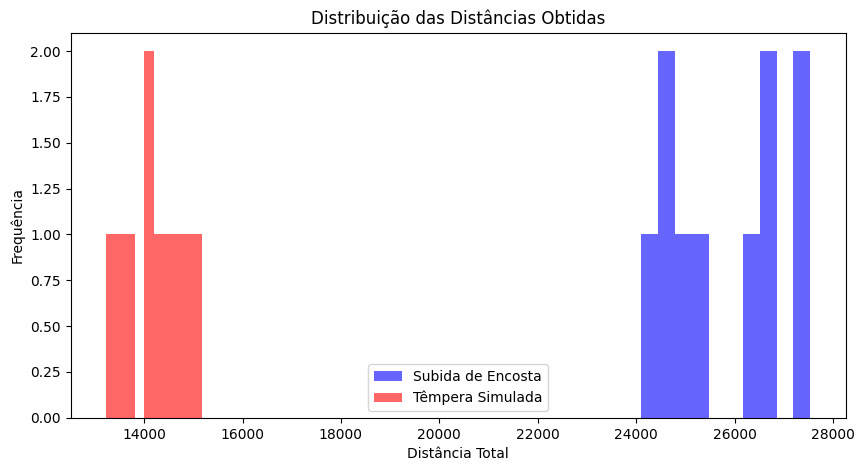

In [62]:
# Criando dir
histogram_comp = "resultados/Histogramas"
os.makedirs(histogram_comp, exist_ok=True)

# Histograma de Comp.
plt.figure(figsize=(10, 5))
plt.hist(hc_results, bins=10, alpha=0.6, label="Subida de Encosta", color="blue")
plt.hist(sa_results, bins=10, alpha=0.6, label="Têmpera Simulada", color="red")
plt.xlabel("Distância Total")
plt.ylabel("Frequência")
plt.title("Distribuição das Distâncias Obtidas")
plt.legend()
filename = os.path.join(histogram_comp, "histograma_comparacao.png")
plt.savefig(filename)

Plotando os dois algoritmos em um único mapa

In [63]:
# Criando dir
together_alg = "resultados/Algoritmos em conjunto"
os.makedirs(together_alg, exist_ok=True)

# Função para plotar os dois algoritmos juntos
def plot_comparison(cities, hc_path, hc_dist, sa_path, sa_dist):
    plt.figure(figsize=(8, 6))

    # Plotar pontos das cidades
    plt.scatter(cities[:, 0], -cities[:, 1], c='black', marker='o', label="Cidades")

    # Traçar caminho da Subida de Encosta (azul)
    ordered_cities_hc = cities[np.append(hc_path, hc_path[0])]
    plt.plot(ordered_cities_hc[:, 0], -ordered_cities_hc[:, 1], 'b-', label=f"Subida de Encosta (Distância: {hc_dist:.2f})")

    # Traçar caminho da Têmpera Simulada (vermelho)
    ordered_cities_sa = cities[np.append(sa_path, sa_path[0])]
    plt.plot(ordered_cities_sa[:, 0], -ordered_cities_sa[:, 1], 'r-', label=f"Têmpera Simulada (Distância: {sa_dist:.2f})")

    plt.legend()
    plt.title("Comparação de Caminhos - Subida de Encosta vs. Têmpera Simulada")
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    filename = os.path.join(together_alg, "alg_conjunto.png")
    plt.savefig(filename)

In [64]:
# Executar os algoritmos
hc_path, hc_dist = hill_climbing(cities)
sa_path, sa_dist = simulated_annealing(cities)

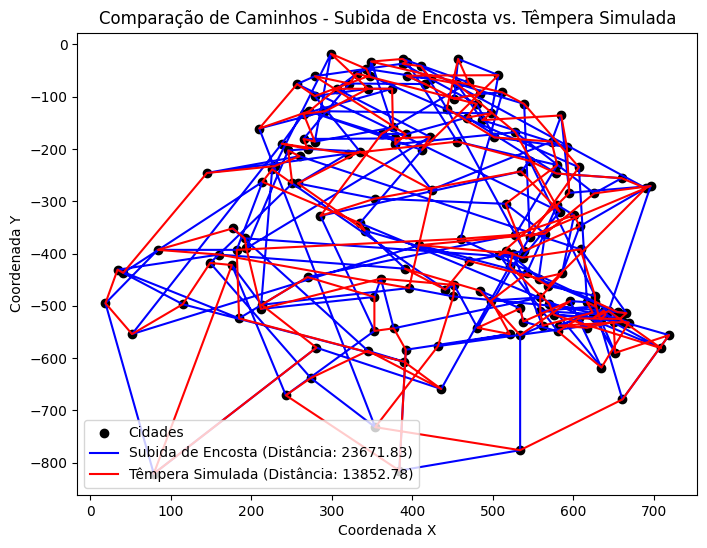

In [65]:
# Plotar a comparação
plot_comparison(cities, hc_path, hc_dist, sa_path, sa_dist)

Distância x Iterações

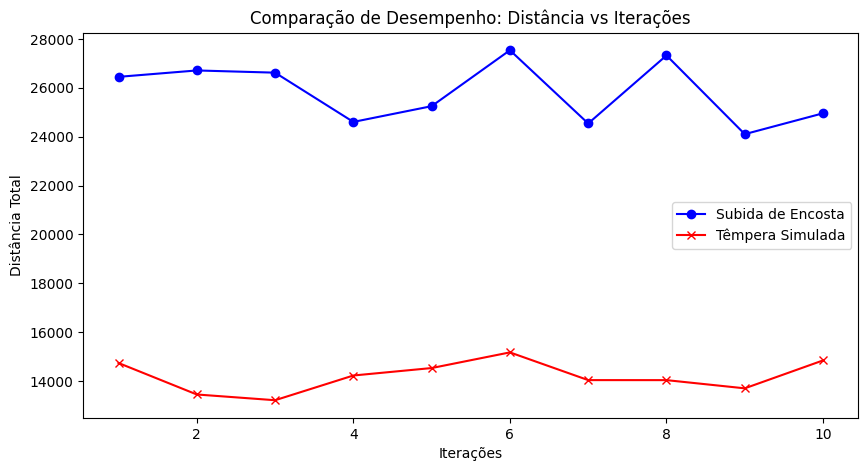

In [66]:
# Criando dir
distance_interations = "resultados/DxI"
os.makedirs(distance_interations, exist_ok=True)

# Gráfico de Comparação de Desempenho
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), hc_results, label="Subida de Encosta", color="blue", marker="o")
plt.plot(range(1, 11), sa_results, label="Têmpera Simulada", color="red", marker="x")
plt.xlabel("Iterações")
plt.ylabel("Distância Total")
plt.title("Comparação de Desempenho: Distância vs Iterações")
plt.legend()
filename = os.path.join(distance_interations, "dxi.png")
plt.savefig(filename)

Verificação de arrays

In [67]:
print(len(hc_results), len(sa_results), len(hc_times), len(sa_times))

10 10 10 10


Tempos de Execução

In [68]:
stats_dir = "resultados/estatisticas_tempo"
os.makedirs(stats_dir, exist_ok=True)

# Criar e salvar estatísticas de cada iteração
for i in range(min_length):
    iter_df = pd.DataFrame({
        "Algoritmo": ["Subida de Encosta", "Têmpera Simulada"],
        "Distância": [hc_results[i], sa_results[i]],
        "Tempo (s)": [hc_times[i], sa_times[i]]
    })

    summary_iter = iter_df.groupby("Algoritmo")["Tempo (s)"].agg(["mean", "min", "max", "std"])

    # Salvar estatísticas de cada iteração em um arquivo txt
    summary_file = os.path.join(stats_dir, f"estatisticas_iteracao_{i+1}.txt")
    with open(summary_file, "w") as f:
        f.write(summary_iter.to_string())

    print(f"Estatísticas da Iteração {i+1} salvas em {summary_file}")

Estatísticas da Iteração 1 salvas em resultados/estatisticas_tempo/estatisticas_iteracao_1.txt
Estatísticas da Iteração 2 salvas em resultados/estatisticas_tempo/estatisticas_iteracao_2.txt
Estatísticas da Iteração 3 salvas em resultados/estatisticas_tempo/estatisticas_iteracao_3.txt
Estatísticas da Iteração 4 salvas em resultados/estatisticas_tempo/estatisticas_iteracao_4.txt
Estatísticas da Iteração 5 salvas em resultados/estatisticas_tempo/estatisticas_iteracao_5.txt
Estatísticas da Iteração 6 salvas em resultados/estatisticas_tempo/estatisticas_iteracao_6.txt
Estatísticas da Iteração 7 salvas em resultados/estatisticas_tempo/estatisticas_iteracao_7.txt
Estatísticas da Iteração 8 salvas em resultados/estatisticas_tempo/estatisticas_iteracao_8.txt
Estatísticas da Iteração 9 salvas em resultados/estatisticas_tempo/estatisticas_iteracao_9.txt
Estatísticas da Iteração 10 salvas em resultados/estatisticas_tempo/estatisticas_iteracao_10.txt


In [69]:
# Criar DataFrame geral
df = pd.DataFrame({
    "Algoritmo": ["Subida de Encosta"] * min_length + ["Têmpera Simulada"] * min_length,
    "Distância": hc_results[:min_length] + sa_results[:min_length],
    "Tempo (s)": hc_times[:min_length] + sa_times[:min_length]
})

# Estatísticas gerais
summary_general = df.groupby("Algoritmo")["Tempo (s)"].agg(["mean", "min", "max", "std"])

# Salvar resumo geral
summary_file_general = os.path.join(stats_dir, "estatisticas_gerais.txt")
with open(summary_file_general, "w") as f:
    f.write(summary_general.to_string())

print(f"Estatísticas gerais salvas em {summary_file_general}")

Estatísticas gerais salvas em resultados/estatisticas_tempo/estatisticas_gerais.txt
